# Testing ClusterDE - Optimized null data

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_17202/2862039534.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_processed.h5ad")


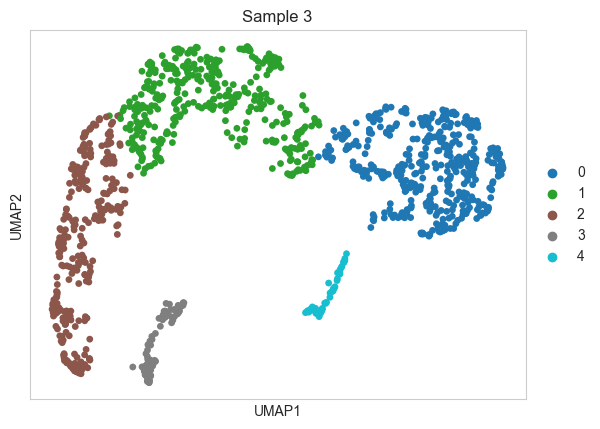

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

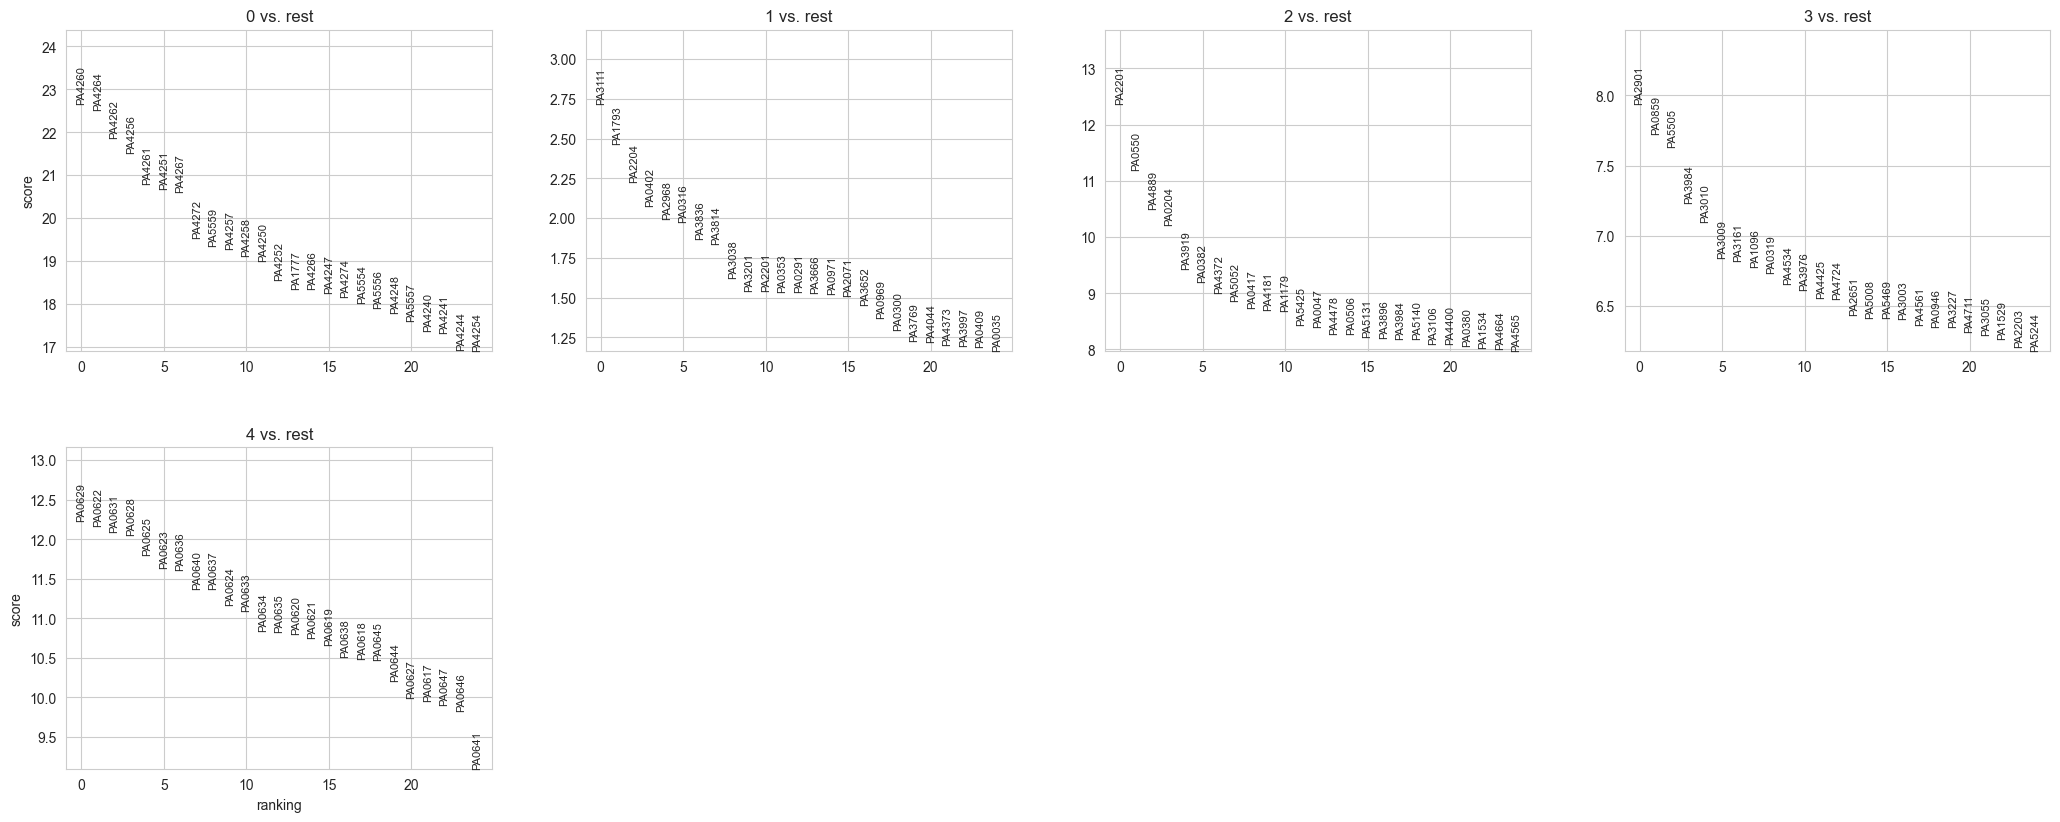

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [31]:
from statsmodels.discrete.count_model import NegativeBinomialP, ZeroInflatedNegativeBinomialP

count_data = data_gene.layers["counts"].toarray()
n, p = count_data.shape

init_zinfs = [len(count_data[:, i][count_data[:, i] == 0]) / n for i in range(p)]
init_means = [np.log(np.mean(count_data[:, i][count_data[:, i] != 0]))
              # if init_zinfs[i] > 0.65 else np.log(np.mean(count_data[:, i]))
              for i in range(p)]
init_ods = [(np.var(count_data[:, i][count_data[:, i] > 0]) - np.mean(count_data[:, i][count_data[:, i] > 0])) / (np.mean(count_data[:, i][count_data[:, i] > 0]))**2
            # if init_zinfs[i] > 0.65 else np.var(count_data[:, i]) - np.mean(count_data[:, i])
            for i in range(p)]

i = 5248
dat = count_data[:, i]

model_nb = NegativeBinomialP(dat, np.ones(n))
res_nb = model_nb.fit(method='bfgs', maxiter=5000,
                      # start_params=[init_means[i], init_ods[i]]
                      )

print(res_nb.summary())

model_zinb = ZeroInflatedNegativeBinomialP(dat, np.ones(n))
res_zinb = model_zinb.fit(method='bfgs', maxiter=5000, start_params=[init_zinfs[i], init_means[i], init_ods[i]])
print(res_zinb.summary())

print(res_nb.converged)

Optimization terminated successfully.
         Current function value: 0.901931
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
                     NegativeBinomialP Regression Results                     
Dep. Variable:                      y   No. Observations:                 1255
Model:              NegativeBinomialP   Df Residuals:                     1254
Method:                           MLE   Df Model:                            0
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:               1.235e-11
Time:                        08:24:25   Log-Likelihood:                -1131.9
converged:                       True   LL-Null:                       -1131.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7805      0.046    -17.0

### Load and process null data

In [6]:
data_null_gen = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/S2_null_data_opt.h5ad")

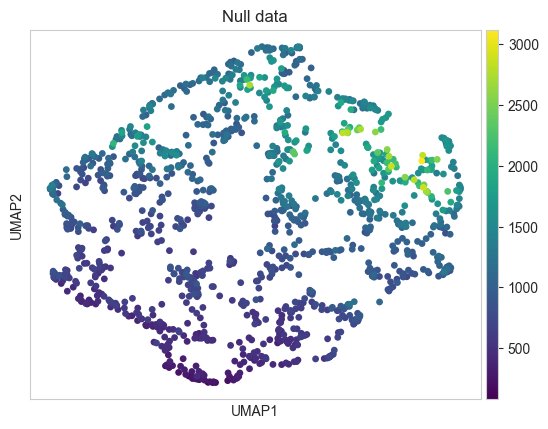

In [7]:

sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [8]:
print(data_null_gen.var["gene_dist"].value_counts())
#print(data_gene.var["gene_dist"].value_counts())


gene_dist
nb     4905
poi     635
Name: count, dtype: int64


In [9]:
res2 = 0.105
sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
nclust = len(data_null_gen.obs["leiden"].unique())
print(nclust)

2


In [10]:
res2 = 0.01
twoclust = False

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
Resolution for two clusters: 0.08


In [11]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()


In [12]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 121; Minimum q value: 0.015625
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 0; Minimum q value: 0.09446022727272728
Cluster 3 - DE genes: 0; Minimum q value: 0.5146067415730337
Cluster 4 - DE genes: 0; Minimum q value: 1.0


In [13]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 3566; Minimum q value: 0.032047089601046436
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 201; Minimum q value: 0.04411764705882353
Cluster 3 - DE genes: 0; Minimum q value: 0.375
Cluster 4 - DE genes: 0; Minimum q value: 1.0


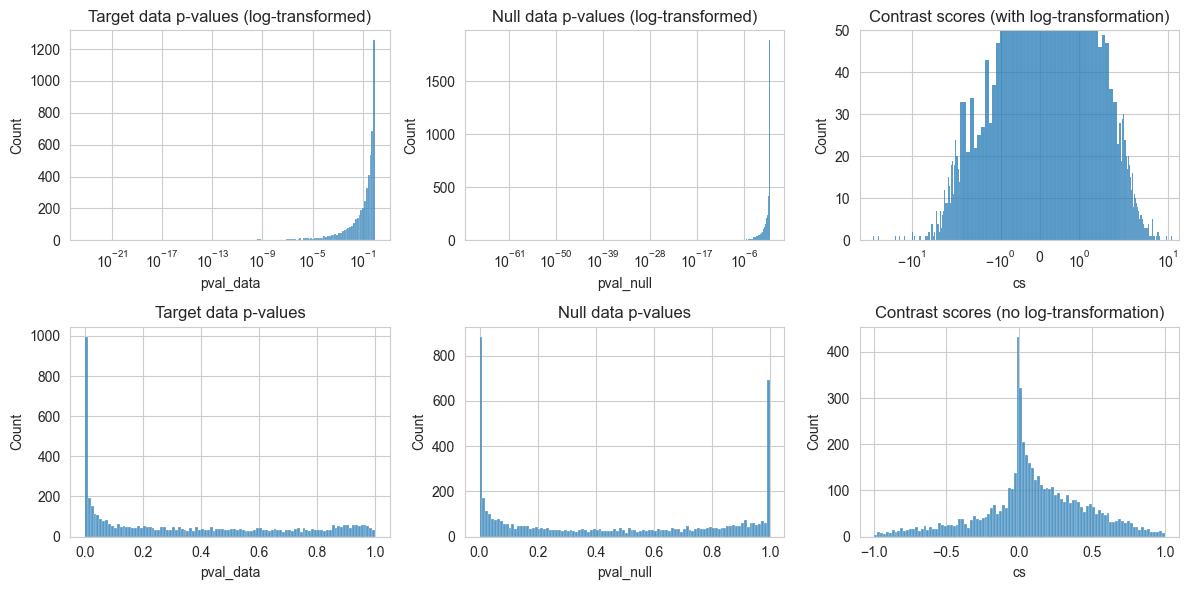

In [14]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

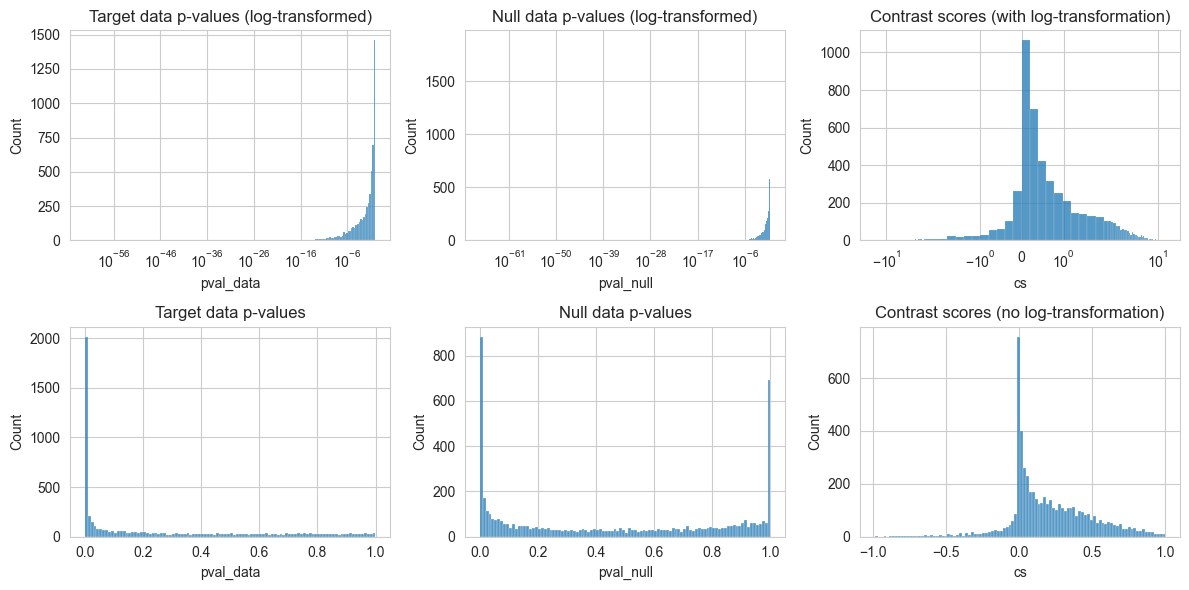

In [15]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [16]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4264,2.438938e-112,5.567315e-62,111.612799,61.254354,50.358445,0.015625
PA4267,2.920381e-94,3.507108e-45,93.534561,44.455051,49.079510,0.015625
PA4244,2.660051e-64,7.037666e-17,63.575110,16.152571,47.422539,0.015625
PA4251,5.612346e-95,3.405209e-49,94.250856,48.467856,45.782999,0.015625
PA4260,1.003996e-113,1.513801e-68,112.998268,67.819931,45.178337,0.015625
...,...,...,...,...,...,...
PA5505,8.743880e-01,7.015507e-07,0.058296,6.153941,-6.095645,1.000000
PA1838,9.027163e-02,3.734446e-08,1.044449,7.427774,-6.383325,1.000000
PA3193,2.333407e-01,1.728862e-08,0.632010,7.762240,-7.130230,1.000000


In [17]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA3744,6.495189e-24,1.496991e-12,23.187408,11.824781,11.362627,0.514607
PA1585,4.316697e-15,4.777740e-04,14.364848,3.320778,11.044071,0.514607
PA0859,1.113857e-14,4.350761e-05,13.953171,4.361435,9.591736,0.514607
PA2742,6.116928e-13,1.927132e-03,12.213467,2.715088,9.498378,0.514607
PA2901,1.999530e-15,2.414313e-06,14.699072,5.617206,9.081866,0.514607
...,...,...,...,...,...,...
PA4256,1.057088e-18,4.534919e-63,17.975889,62.343431,-44.367542,1.000000
PA4264,4.986440e-16,5.567315e-62,15.302209,61.254354,-45.952145,1.000000
PA4260,7.502146e-22,1.513801e-68,21.124815,67.819931,-46.695117,1.000000


SignificanceResult(statistic=0.9999999062055832, pvalue=0.0)
[[1.        0.9439868]
 [0.9439868 1.       ]]


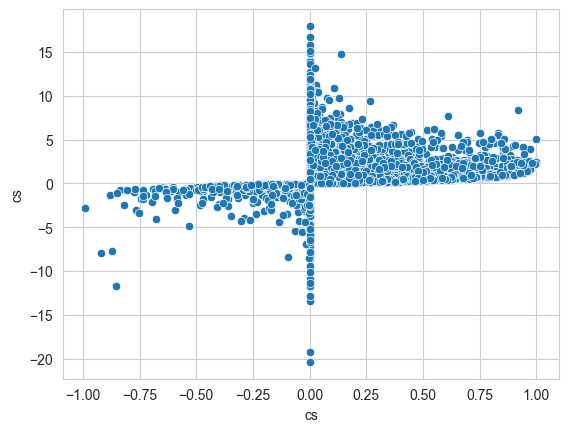

In [18]:
sns.scatterplot(x = pvals_gen["2"]["cs"], y = pvals_log_gen["2"]["cs"])

from scipy.stats import spearmanr
print(spearmanr(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))
print(np.corrcoef(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))


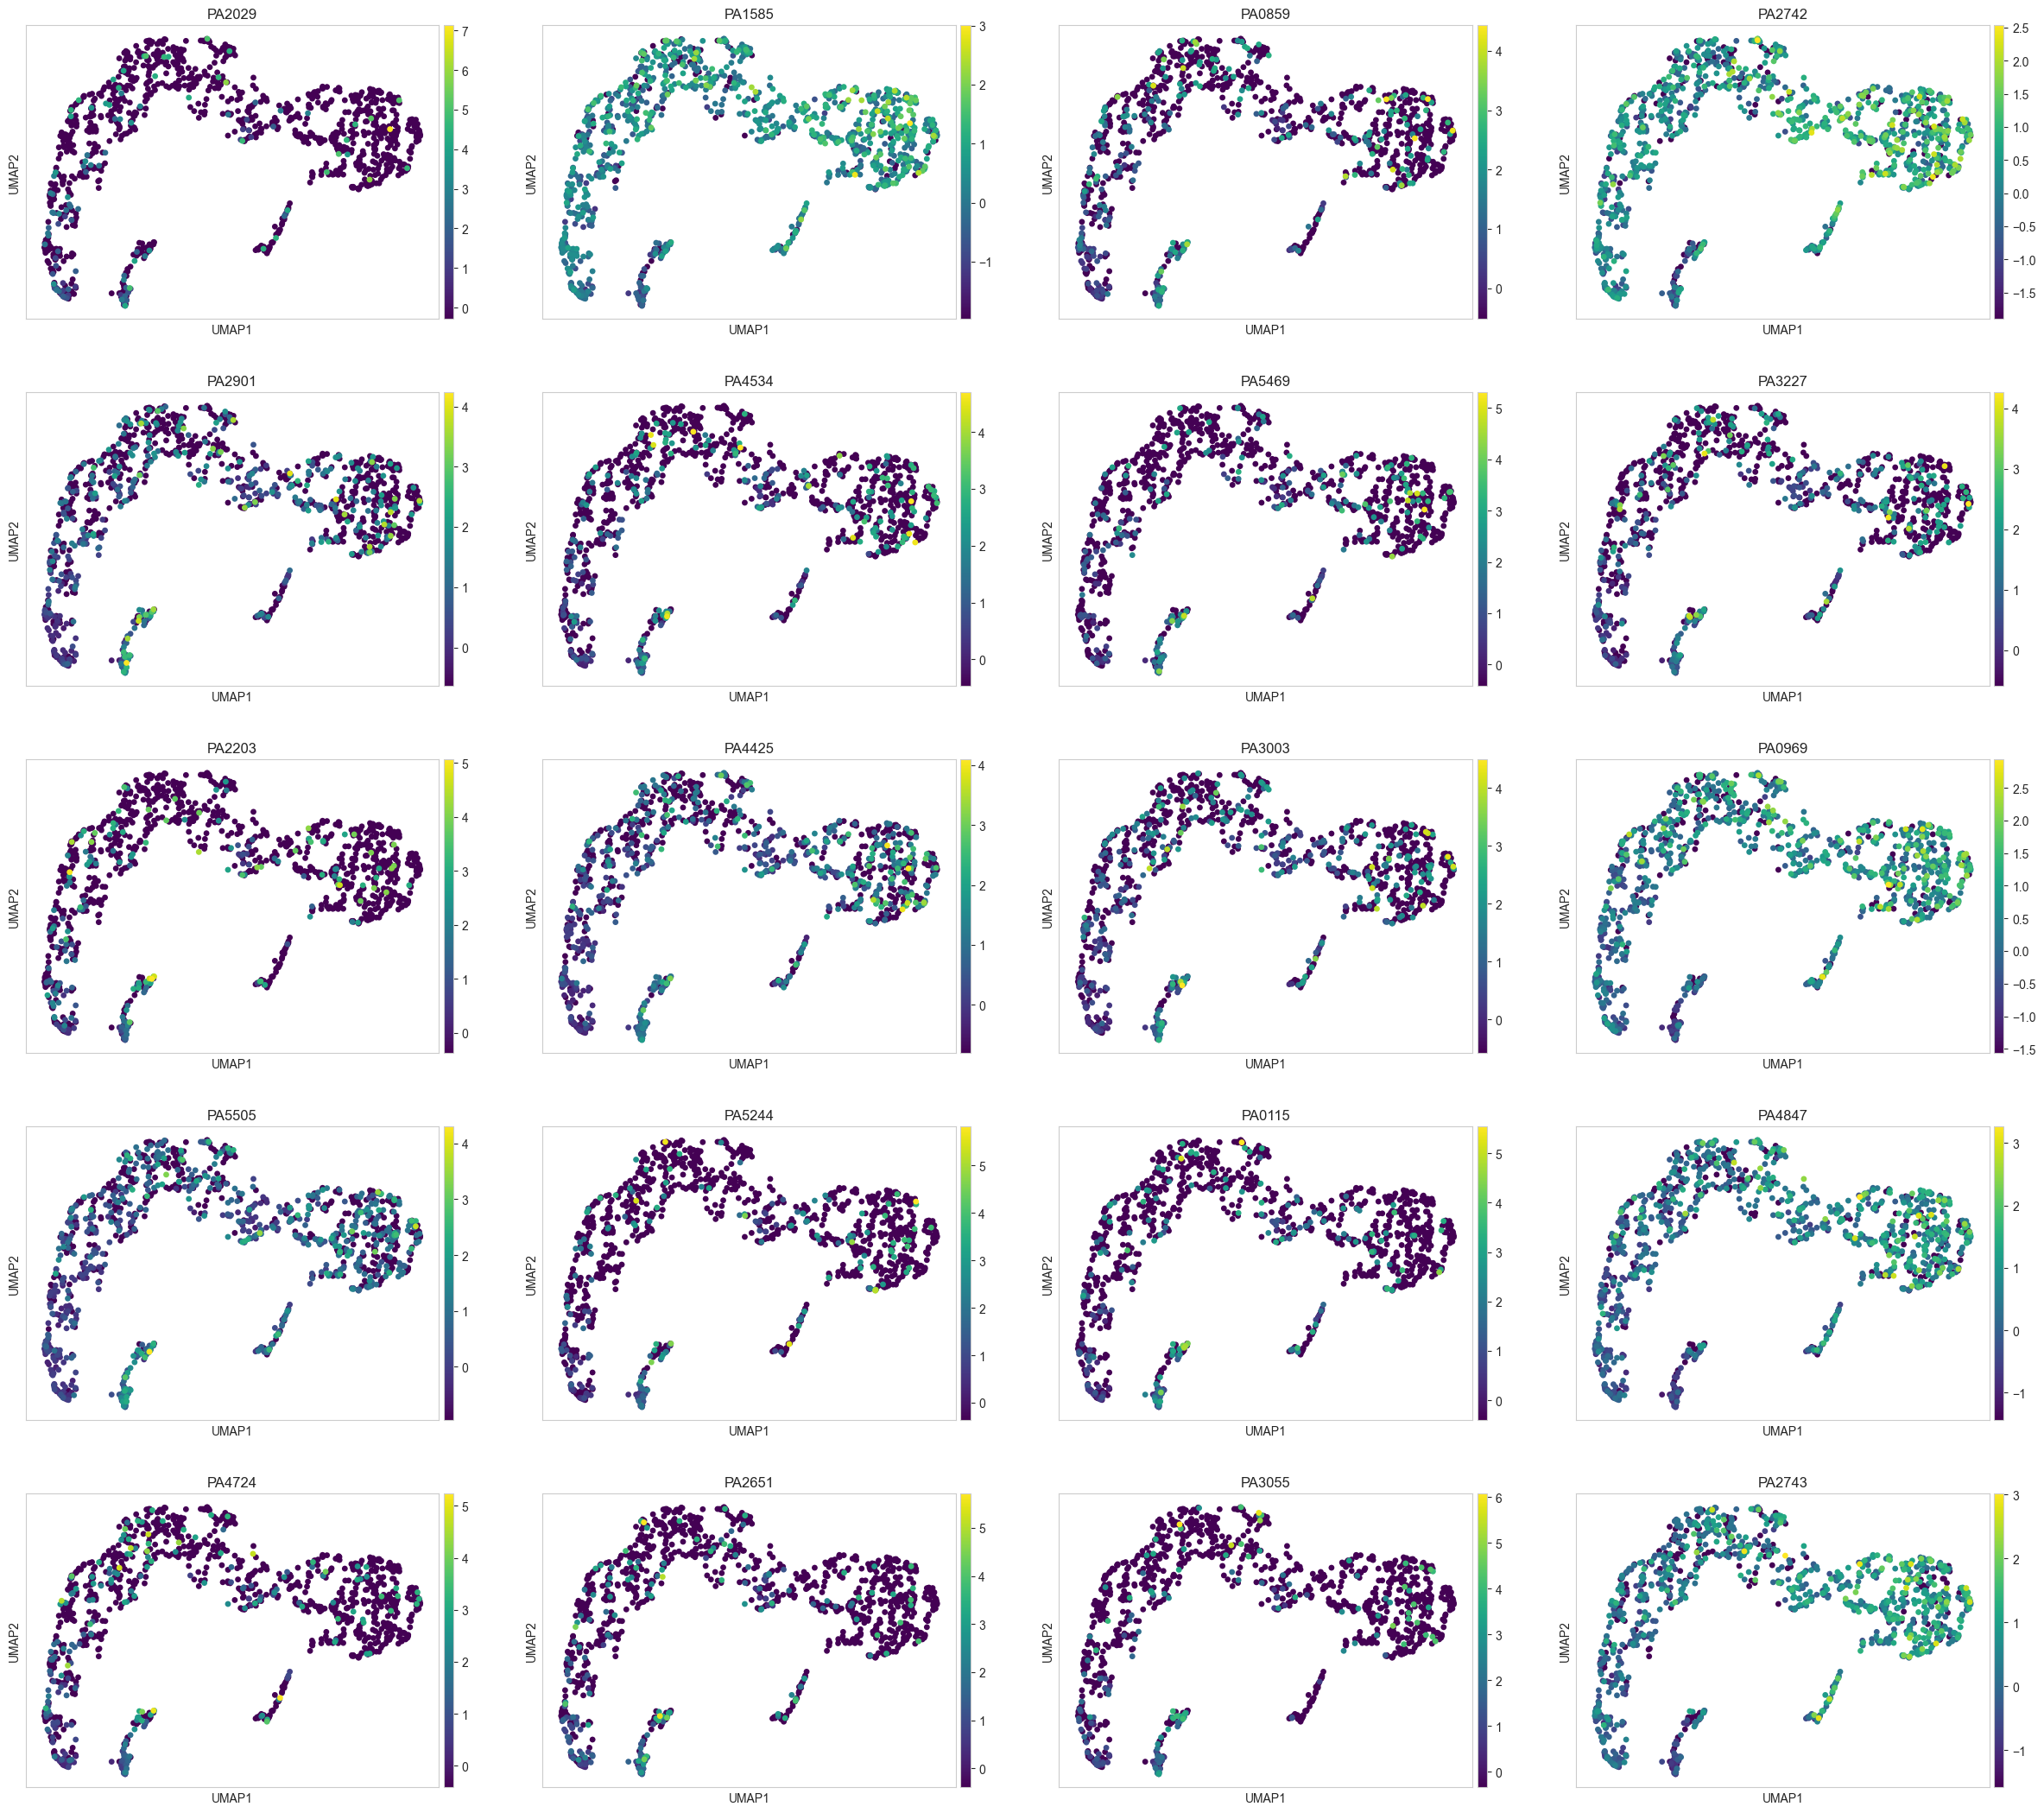

In [19]:
sc.pl.umap(data_gene, color=pvals_log_gen["3"].sort_values("q", ascending=True).index.tolist()[:20], cmap="viridis")


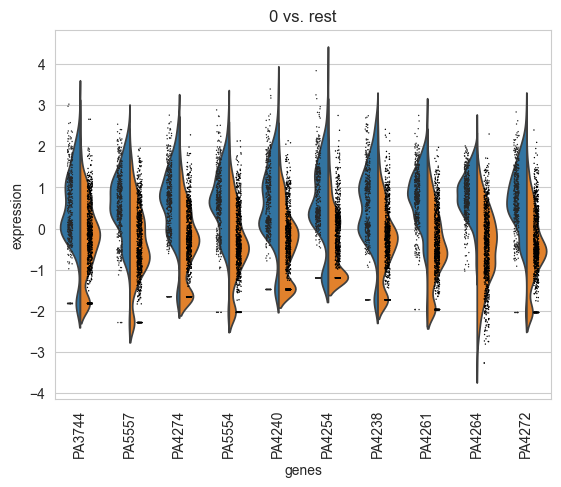

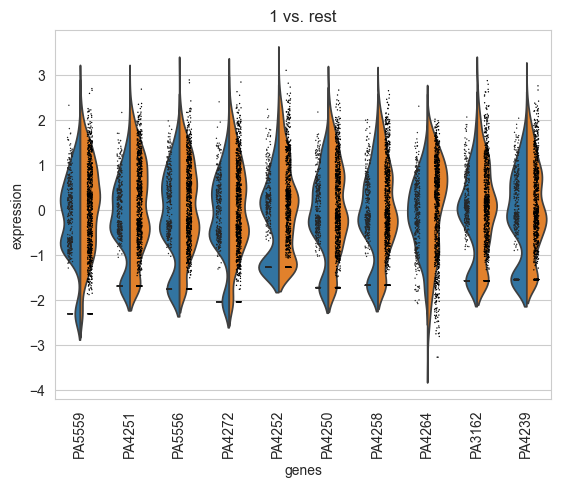

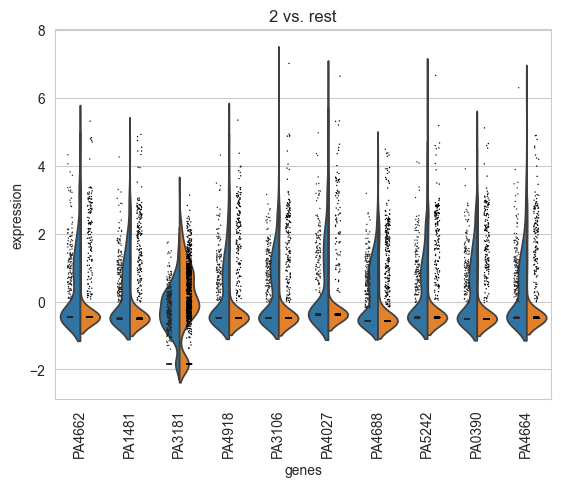

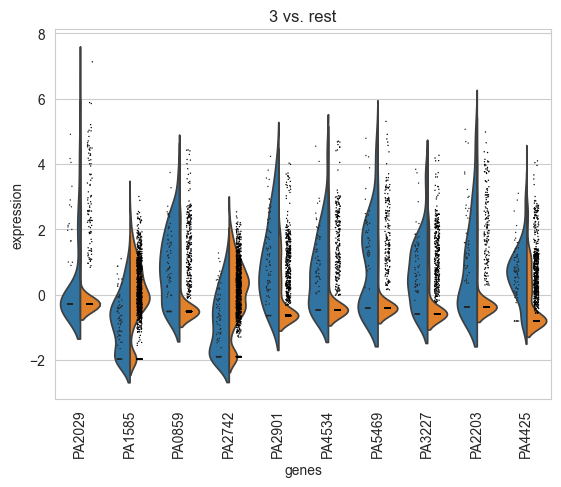

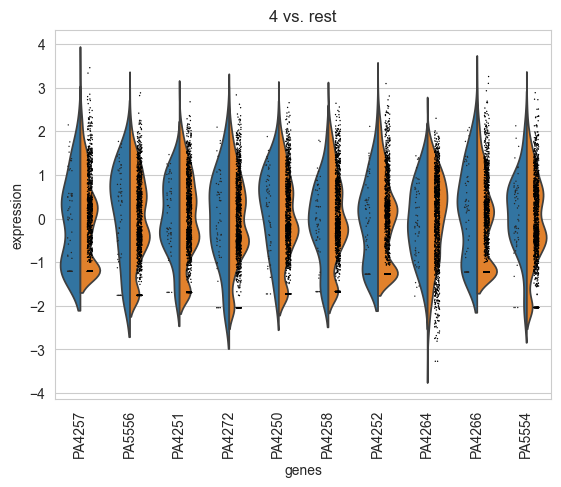

In [20]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), gene_names=pvals_log_gen[str(i)].sort_values("q", ascending=True).index.tolist()[:10])

In [21]:
pvals_log_gen["3"].to_csv("pvals_3.csv")